In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy
import random
import time
from IPython.display import display, clear_output

import gymnasium as gym

from collections import defaultdict, deque
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.plots import *
from utils.models import *

In [2]:
CONFIG = {
    'DDPG': {
        'Pendulum-v1': {
            'gamma': 0.99,
            'total_steps': 40_000,
            'sigma': 0.15,
            'policy_lr': 1e-4,
            'qnet_lr': 1e-3,
            'tau': 0.005,
            'learning_starts': 2000,
            'max_buffer_size': 100_000,
            'batch_size': 256,
            'q_hidden_sizes': [64,64],
            'policy_hidden_sizes': [64,64],
        },
        
        'InvertedDoublePendulum-v5': {
            'gamma': 0.99,
            'total_steps': 100_000,
            'sigma': 0.15,  
            'policy_lr': 1e-4,
            'qnet_lr': 1e-3,
            'tau': 0.005,
            'learning_starts': 5000,
            'max_buffer_size': 200_000,
            'batch_size': 64,
            'q_hidden_sizes': [256, 256],
            'policy_hidden_sizes': [256, 256],
        },
        'Hopper-v5': {
            'gamma': 0.99,
            'total_steps': 1_000_000,    
            'sigma': 0.2,        
            'policy_lr': 1e-4,
            'qnet_lr': 1e-3,
            'tau': 0.005,
            'learning_starts': 10_000,
            'max_buffer_size': 1_000_000, 
            'batch_size': 256,
            'q_hidden_sizes': [400, 300],   
            'policy_hidden_sizes': [400, 300],
        },
        
        'BipedalWalker-v3': {
            'gamma': 0.99,
            'total_steps': 100_000,
            'sigma': 0.1,
            'policy_lr': 3e-4,
            'qnet_lr': 3e-4,
            'tau': 0.005,
            'learning_starts': 5000,
            'max_buffer_size': 200_000,
            'batch_size': 128,
            'q_hidden_sizes': [64,64],
            'policy_hidden_sizes': [64,64],
        },
    },
    'MLPPolicy_hidden_sizes': [64,64],
    'animation': {
        'FPS': 45,
        'do_truncate': True,
    },
    'plots_info': {
        'subplt_shape': (2,2),
        'figsize': (12,4),
        'subplts_info': [
            {'key': "rewards",
            'title': "Smoothed Rewards",
            'xlabel': "Episodes",
            'ylabel': "Reward"},
            
            {'key': "q_loss",
            'title': "Smooth Q Loss",
            'xlabel': "Timesteps",
            'ylabel': "Loss"},
            
            {'key': "policy_loss",
            'title': "Smooth Policy Loss",
            'xlabel': "Timesteps",
            'ylabel': "Loss"},

            {'key': "ep_length",
            'title': "Smooth Episode Lengths",
            'xlabel': "Episodes",
            'ylabel': "Steps"},
        ],
    },
}

In [3]:
pendulum_env = gym.make("Pendulum-v1", render_mode = 'rgb_array')
cartpole_env = gym.make("InvertedDoublePendulum-v5", render_mode = 'rgb_array')
hopper_env = gym.make("Hopper-v5", render_mode = 'rgb_array')
bipedal_env = gym.make("BipedalWalker-v3", render_mode= 'rgb_array')

In [4]:
def DDPG(env, gamma = 1.0, total_steps = 1e5, sigma = 0.1,
         policy_lr = 1e-4, qnet_lr = 1e-3, tau = 0.005,
         learning_starts = 5000, max_buffer_size = 100_000, batch_size = 32,
         q_hidden_sizes = [64,64], policy_hidden_sizes = [64,64]):
  
    s_dims = env.observation_space.shape[0]
    a_dims = env.action_space.shape[0]
    a_low = torch.tensor(env.action_space.low)
    a_high = torch.tensor(env.action_space.high)

    stats = {'ep_length': [],
             'q_loss': [],
             'policy_loss': [],
             'rewards': []}

    mse_loss = nn.MSELoss()
    
    Q = QNet(s_dims, a_dims, q_hidden_sizes)
    Q_target = QNet(s_dims, a_dims, q_hidden_sizes)

    policy = DDPGPolicy(s_dims, a_dims, a_low, a_high, policy_hidden_sizes)
    policy_target = DDPGPolicy(s_dims, a_dims, a_low, a_high,  policy_hidden_sizes)

    policy_optimizer = torch.optim.Adam(policy.parameters(), lr = policy_lr)
    Q_optimizer = torch.optim.Adam(Q.parameters(), lr = qnet_lr)

    replay_buffer = deque(maxlen = max_buffer_size)
    
    n_steps = 0
    prev_rsum = 0.0
    while n_steps < total_steps:

        s,_ = env.reset()
        r_sum = 0.0
        T = 0
        while True:
            noise = torch.normal(0, sigma, size=torch.zeros(a_dims).size())
            a = torch.clip(policy(torch.FloatTensor(s)) + noise, a_low, a_high).detach().numpy()
            
            s_n, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            
            n_steps += 1
            T += 1
            r_sum += r
            
            replay_buffer.append((s, a, r, s_n, done))
            
            if terminated or truncated:
                stats['rewards'].append(r_sum)
                prev_rsum = r_sum
                stats['ep_length'].append(T)
                break

                
            s = s_n

            if n_steps > learning_starts:
                batch = random.sample(replay_buffer, batch_size)
                
                s_batch = torch.FloatTensor(np.array([t[0] for t in batch]))
                a_batch = torch.FloatTensor(np.array([t[1] for t in batch]))
                r_batch = torch.FloatTensor([t[2] for t in batch]).unsqueeze(1)
                s_next_batch = torch.FloatTensor([t[3] for t in batch])
                done_batch = torch.FloatTensor([t[4] for t in batch]).unsqueeze(1)

                with torch.no_grad():
                    targets = r_batch + gamma*(1-done_batch)*Q_target(s_next_batch, policy_target(s_next_batch))
                
                Q_optimizer.zero_grad()
                q_loss = mse_loss(Q(s_batch, a_batch), targets).mean()
                stats['q_loss'].append(q_loss.item())
                q_loss.backward()
                Q_optimizer.step()
                
                policy_optimizer.zero_grad()
                policy_loss = -torch.mean(Q(s_batch, policy(s_batch)))
                stats['policy_loss'].append(policy_loss.item())
                policy_loss.backward()
                policy_optimizer.step()

                for target_param, param in zip(Q_target.parameters(), Q.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                
                for target_param, param in zip(policy_target.parameters(), policy.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            if n_steps % 10 == 0 or n_steps >= total_steps:
                ep_len = 0.0 if len(stats['ep_length']) == 0 else stats['ep_length'][-1]
                print(f'\rStep : {n_steps}/{total_steps} ({100*n_steps/total_steps:.2f}%) -- Reward : {prev_rsum:.2f} -- ep_length : {ep_len}  ', end = '')

    return Q, policy, stats

In [5]:
class DeterministicToGaussian(nn.Module):
    def __init__(self, mlp_policy):
        super().__init__()
        self.policy = mlp_policy

    def forward(self, state):
        mu = self.policy(state)
        return mu, torch.zeros_like(mu) + 1e-6

In [6]:
Q_pendulum, pendulum_policy, pendulum_stats = DDPG(pendulum_env, **CONFIG['DDPG']['Pendulum-v1'])

Step : 1990/40000 (4.97%) -- Reward : -1165.72 -- ep_length : 200  

/var/folders/w4/sxkjd5zd0476t4bx611w14j40000gn/T/ipykernel_93129/3638929156.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  s_next_batch = torch.FloatTensor([t[3] for t in batch])


Step : 39990/40000 (99.97%) -- Reward : -267.75 -- ep_length : 200   

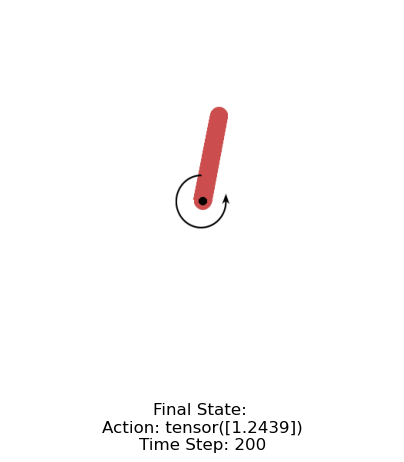

In [13]:
pendulum_policy_gaussian = DeterministicToGaussian(pendulum_policy)

animate_policy(pendulum_env, pendulum_policy_gaussian, None, True)

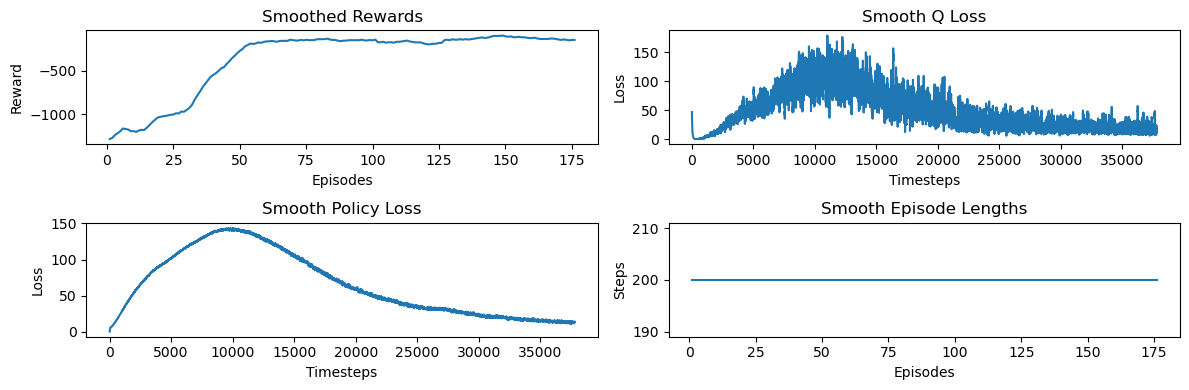

In [14]:
plot_stats(pendulum_stats, CONFIG['plots_info'], 25)

In [27]:
Q_cartpole, cartpole_policy, cartpole_stats = DDPG(cartpole_env, **CONFIG['DDPG']['InvertedDoublePendulum-v5'])

Step : 100043/100000 (100.04%) -- Reward : 626.34 -- ep_length : 69   

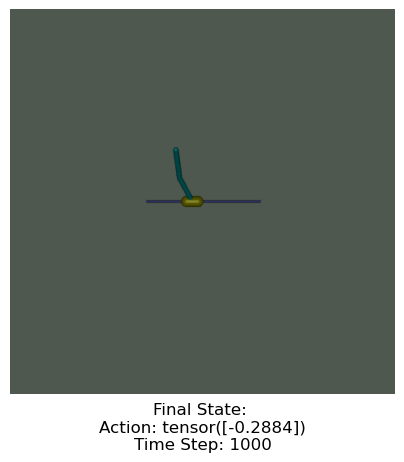

In [29]:
cartpole_policy_gaussian = DeterministicToGaussian(cartpole_policy)

animate_policy(cartpole_env, cartpole_policy_gaussian, None, True)

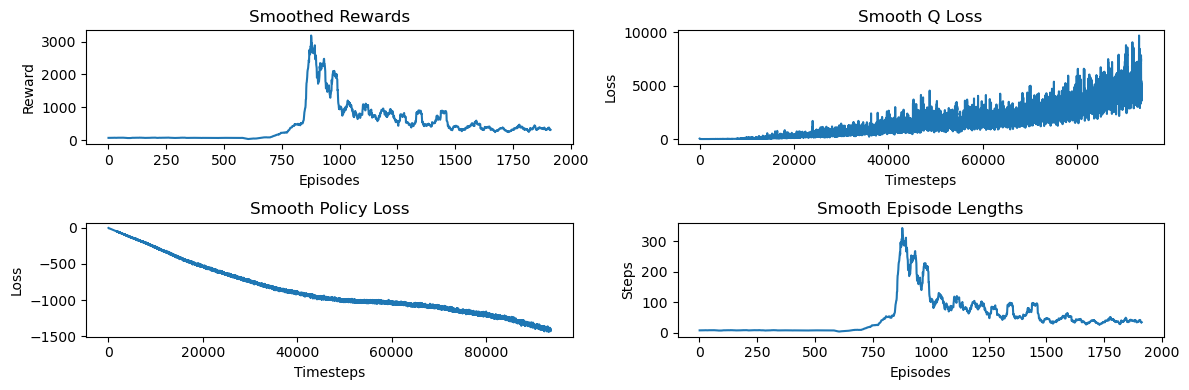

In [30]:
plot_stats(cartpole_stats, CONFIG['plots_info'], 25)